<a href="https://colab.research.google.com/github/cdevi-star/test/blob/main/Brain_Tumor_Detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
navoneel_brain_mri_images_for_brain_tumor_detection_path = kagglehub.dataset_download('navoneel/brain-mri-images-for-brain-tumor-detection')

print('Data source import complete.')


Data source import complete.


In [27]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
import warnings

warnings.filterwarnings("ignore")

In [32]:
import kagglehub
import os
import cv2

# Download latest version
path = kagglehub.dataset_download("navoneel/brain-mri-images-for-brain-tumor-detection")
print("Path to dataset files:", path)

# Update directory paths based on the downloaded dataset path
no_tumor_dir = os.path.join(path, 'no')  # Corrected path
yes_tumor_dir = os.path.join(path, 'yes') # Corrected path

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
    return images

no_tumor_images = load_images_from_folder(no_tumor_dir)
yes_tumor_images = load_images_from_folder(yes_tumor_dir)

Path to dataset files: /root/.cache/kagglehub/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/versions/1


# Load the Images

In [39]:
no_tumor_labels = [0] * len(no_tumor_images)
yes_tumor_labels = [1] * len(yes_tumor_images)

In [40]:
X = np.array(no_tumor_images + yes_tumor_images)
y = np.array(no_tumor_labels + yes_tumor_labels)

# Inspect our Data

In [41]:
print("Initial shape or dimensions of X", str(X.shape))

print ("Number of samples in our data: " + str(len(X)))
print ("Number of labels in our data: " + str(len(y)))


print("\n")
print ("Dimensions of images:" + str(X[0].shape))

Initial shape or dimensions of X (253, 128, 128, 3)
Number of samples in our data: 253
Number of labels in our data: 253


Dimensions of images:(128, 128, 3)


<Figure size 640x480 with 0 Axes>

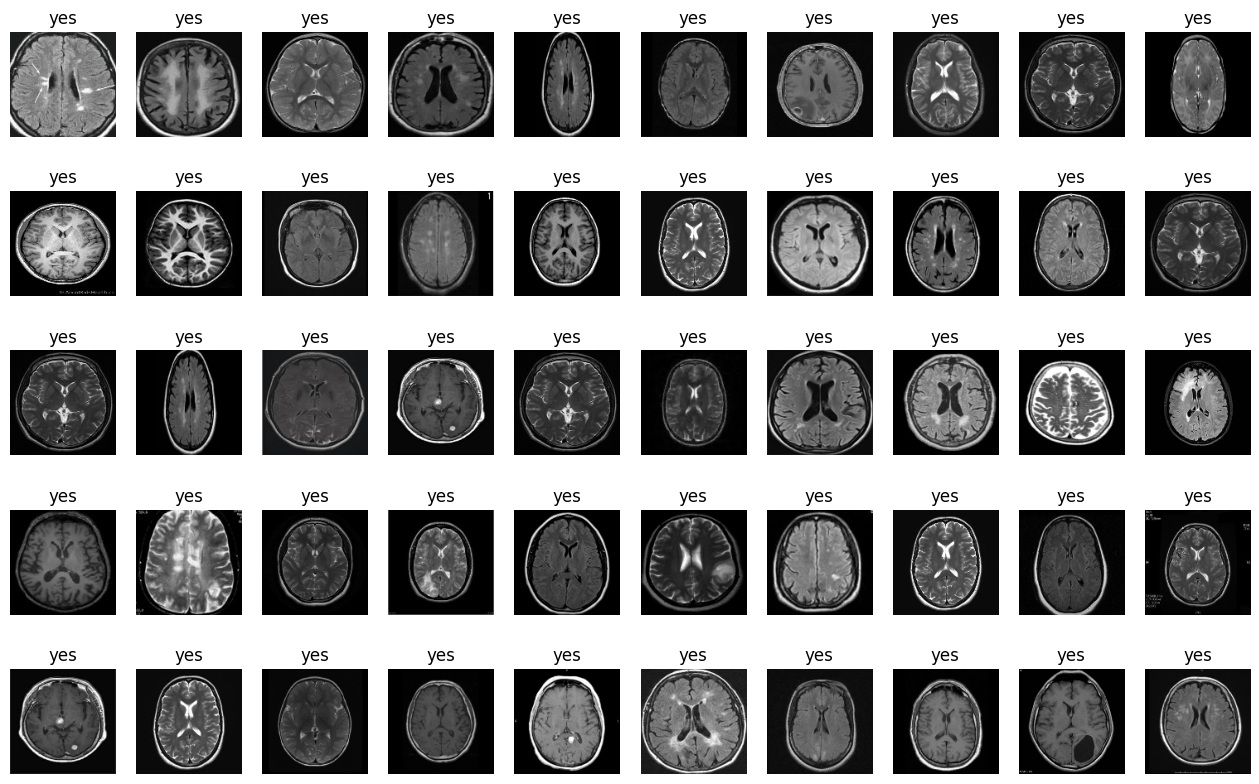

In [42]:
import matplotlib.pyplot as plt

figure = plt.figure()
plt.figure(figsize=(16,10))

num_of_images = 50

classes = ["yes", "no"]

for index in range(1, num_of_images + 1):
    class_names = classes[y[index]]
    plt.subplot(5, 10, index).set_title(f'{class_names}')
    plt.axis('off')
    plt.imshow(X[index], cmap='gray_r')

# Data Preprocessing

In [44]:
X = X.astype('float32')

In [45]:
img_rows = X[0].shape[0]
img_cols = X[0].shape[1]

In [46]:
input_shape = (img_rows, img_cols, 3)

X /= 255.0
y = to_categorical(y, num_classes=2)

# Train Test Split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [48]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Model Building

In [49]:
L2 = 0.001

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer = SGD(0.01),
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,578 (28.20 MB)

 Trainable params: 7,392,578 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

None


In [50]:
history = model.fit(X_train, y_train, batch_size = 8,
                              epochs = 25,
                              validation_data = (X_test, y_test),
                              verbose = 1,)

Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.6600 - loss: 0.6286 - val_accuracy: 0.7843 - val_loss: 0.4759
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.7260 - loss: 0.5595 - val_accuracy: 0.8235 - val_loss: 0.4345
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 236ms/step - accuracy: 0.7631 - loss: 0.5281 - val_accuracy: 0.7843 - val_loss: 0.4217
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - accuracy: 0.7542 - loss: 0.4950 - val_accuracy: 0.8235 - val_loss: 0.4698
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.8295 - loss: 0.4403 - val_accuracy: 0.7451 - val_loss: 0.4966
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.8286 - loss: 0.4258 - val_accuracy: 0.8627 - val_loss: 0.3693
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - accuracy: 0.8787 - loss: 0.3425 - val_accuracy: 0.7843 - val_loss: 0.4219
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.8638 - loss: 0.3683 - val_accurac

In [52]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


In [53]:
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.70      0.74        20
           1       0.82      0.87      0.84        31

    accuracy                           0.80        51
   macro avg       0.80      0.79      0.79        51
weighted avg       0.80      0.80      0.80        51



<Axes: >

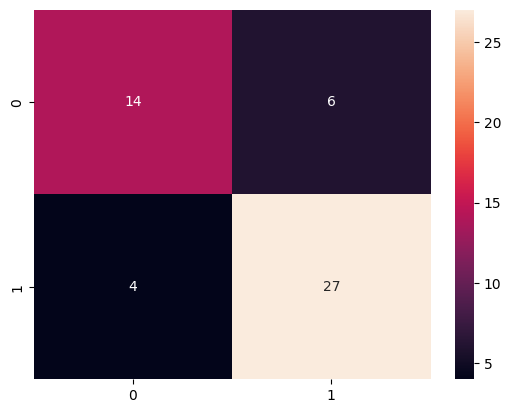

In [54]:
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True)